In [1]:
import numpy as np
import pandas as pd
import nilearn
import nibabel
import matplotlib.pyplot as plt
import seaborn as sns
import os,sys,glob
from nibabel.freesurfer.io import read_annot, read_label
from scipy.stats import zscore
from nilearn.datasets import fetch_surf_fsaverage
from nilearn import surface
from nilearn import plotting
from scipy.spatial.distance import cdist, pdist, squareform

/gpfs/milgram/project/casey/elb77/conda_envs/env_tda/lib/python3.7/site-packages/nilearn/__init__.py:69: FutureWarning: Python 3.7 support is deprecated and will be removed in release 0.12 of Nilearn. Consider switching to Python 3.9 or 3.10.
  _python_deprecation_warnings()


In [2]:
data_path = "/gpfs/milgram/project/turk-browne/projects/StudyForrest/fmri_meg_aligned_segments"
fmri_fn = f'{data_path}/fmri/fsaverage_trimmed/fmri_sub-01_ses-movie_task-movie_run-01_fmri_resampled_trimmed_'
meg_fn = f'{data_path}/meg/trimmed_new/meg_sub-02_ses-movie_task-movie_run-01_trimmed_src_part-01.npy'
Xf = zscore(np.nan_to_num(np.concatenate((np.load(fmri_fn+'lh.npy'), np.load(fmri_fn+'rh.npy')),axis=1)), axis=0)
Xm = zscore(np.load(meg_fn).T, axis=0)
Xf.shape, Xm.shape

((450, 20484), (20000, 20484))

In [ ]:
def downsample(data, rate):
    ns, nf = data.shape
    

Xmd = 

In [5]:
## these come from: https://github.com/ThomasYeoLab/CBIG/tree/master/stable_projects/brain_parcellation/Schaefer2018_LocalGlobal/Parcellations/FreeSurfer5.3/fsaverage5
label_path='./Shaefer2018_LocalGlobal/' 

# labels_rh += 100 # increment to get 100-200

labels_rh, ctab_rh, names_rh = read_annot(label_path+'rh.Schaefer2018_200Parcels_Kong2022_17Networks_order.annot')
labels_lh, ctab_lh, names_lh = read_annot(label_path+'lh.Schaefer2018_200Parcels_Kong2022_17Networks_order.annot')
print(names_lh[1], names_rh[1])

b'17networks_LH_DefaultA_IPL_1' b'17networks_RH_DefaultA_IPL_1'


In [7]:
## these come from: https://github.com/ThomasYeoLab/CBIG/tree/master/stable_projects/brain_parcellation/Schaefer2018_LocalGlobal/Parcellations/FreeSurfer5.3/fsaverage5
label_path='./Shaefer2018_LocalGlobal/' 

# labels_rh += 100 # increment to get 100-200

labels_rh, ctab_rh, names_rh = read_annot(label_path+'rh.Schaefer2018_200Parcels_Kong2022_7Networks_order.annot')
labels_lh, ctab_lh, names_lh = read_annot(label_path+'lh.Schaefer2018_200Parcels_Kong2022_7Networks_order.annot')
print(names_lh[1], names_rh[1])

FileNotFoundError: [Errno 2] No such file or directory: './Shaefer2018_LocalGlobal/rh.Schaefer2018_200Parcels_Kong2022_7Networks_order.annot'

In [6]:
names_lh[2]

b'17networks_LH_DefaultA_PFCm_1'

In [4]:
labels_lh[1],names_lh[1]

(61, b'17networks_LH_DefaultA_IPL_1')

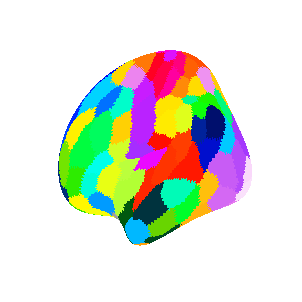

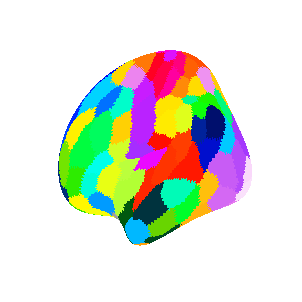

In [13]:
fsaverage_surface = fetch_surf_fsaverage(mesh='fsaverage5')
inflated_mesh_lh = fsaverage_surface["infl_left"]
sulc_mesh_lh = fsaverage_surface['sulc_left']

# plot left hemisphere regions
plotting.plot_surf_roi(inflated_mesh_lh, labels_lh, hemi='left', view='lateral', bg_map=sulc_mesh_lh)

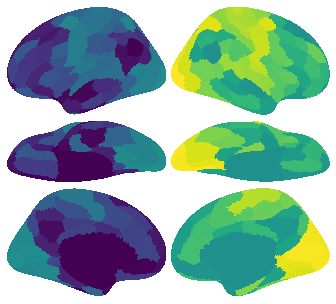

In [18]:
# I prefer plotting with this which has lacking documentation  : https://pypi.org/project/brainplotlib/
import brainplotlib as bpl
img = bpl.brain_plot(np.concatenate((labels_lh, labels_rh+100)), vmin=0, vmax=200) # increment by 100 to get unique for each hemisphere
fig = plt.figure(figsize=(img.shape[1] / 200, img.shape[0] / 200), dpi=50)
plt.axis('off')
plt.imshow(img)


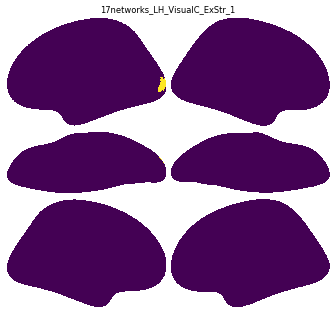

In [58]:
# get data for just one region (lets say 17networks_LH_VisualA_ExStr_1
region='17networks_LH_VisualC_ExStr_1'
idx_lh = [name.decode() for name in names_lh].index(region)

data = np.zeros(10242*2)
data[np.where(labels_lh == idx)[0]] = 1

img = bpl.brain_plot(data, vmin=0, vmax=1) 
fig = plt.figure(figsize=(img.shape[1] / 200, img.shape[0] / 200), dpi=50)
plt.axis('off')
plt.title(region)
plt.imshow(img)

In [61]:
# extract data from a region - same region in each hemisphere
region_id = 4
idx_lh = np.where(labels_lh == region_id)[0]
idx_rh = np.where(labels_rh == region_id)[0] + 10242 # adjust by 10242 to get the right hemisphere indexing if they're concatenated
roi_data_lh = Xf[:, idx_lh]
print(roi_data_lh.shape)
roi_data_rh = Xf[:, idx_rh]
print(roi_data_rh.shape)

(450, 122)
(450, 134)


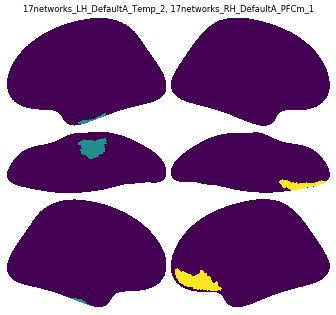

In [61]:
# plot these regions back on the surface
mask = np.zeros(10242*2)
mask[idx_lh] = 1
mask[idx_rh] = 2

name_lh = [n.decode() for n in names_lh][region_id]
name_rh = [n.decode() for n in names_rh][region_id]


img = bpl.brain_plot(mask, vmin=0, vmax=2) 
fig = plt.figure(figsize=(img.shape[1] / 200, img.shape[0] / 200), dpi=50)
plt.axis('off')
plt.title(f'{name_lh}, {name_rh}')
plt.imshow(img)

In [63]:
## easiest way to work with these since our data is concatenated across hemispheres is to do this:

labels_lh, _, names_lh = read_annot(label_path+'lh.Schaefer2018_200Parcels_Kong2022_17Networks_order.annot')
labels_rh, _, names_rh = read_annot(label_path+'rh.Schaefer2018_200Parcels_Kong2022_17Networks_order.annot')
labels_rh += 100 # increment to get 100-200
labels = np.concatenate((labels_lh, labels_rh))
names = np.concatenate((names_lh, names_rh))

print(labels.shape, names.shape)

np.save('Schaefer2018_200Parcels_Kong2022_17Networks_order_labels.npy', labels)
np.save('Schaefer2018_200Parcels_Kong2022_17Networks_order_names.npy', names)


(20484,) (202,)


In [4]:
labels = np.load('Schaefer2018_200Parcels_Kong2022_17Networks_order_labels.npy')

In [9]:
np.max(labels)

200

In [13]:
def parcellate_data(data, labels):
    samples, features = data.shape
    n_parcels = len(np.unique(labels))-1 # account for background
    parcellated_data = np.zeros((samples, n_parcels))
    for i in range(n_parcels):
        # get data at that parcel
        parcel_data = data[:, np.where((labels == i+1))[0]]
        parcellated_data[:, i] = np.nanmean(parcel_data,axis=1) # average across voxels
    return parcellated_data

In [21]:
a = parcellate_data(Xm, labels)
a.shape

(20000, 200)

<AxesSubplot:>

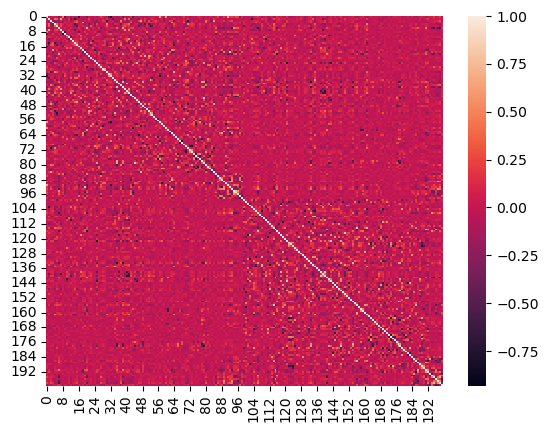

In [22]:
sns.heatmap(1-squareform(pdist(a.T, 'correlation')))

In [4]:
import utils

In [ ]:
A = utils._single_sub_meg(2,1, downsamp=500)
A.shape

In [5]:
import os
os.listdir(f'{utils.root_dir}/fmri/graphs/')

['fmri_sub-01_ses-movie_task-movie_FC_graph_shaefer_parcellation.npy',
 'fmri_sub-02_ses-movie_task-movie_FC_graph_shaefer_parcellation.npy',
 'fmri_sub-17_ses-movie_task-movie_FC_graph_shaefer_parcellation.npy',
 'fmri_sub-20_ses-movie_task-movie_FC_graph_shaefer_parcellation.npy',
 'fmri_sub-19_ses-movie_task-movie_FC_graph_shaefer_parcellation.npy',
 'fmri_sub-18_ses-movie_task-movie_FC_graph_shaefer_parcellation.npy',
 'fmri_sub-09_ses-movie_task-movie_FC_graph_shaefer_parcellation.npy',
 'fmri_sub-10_ses-movie_task-movie_FC_graph_shaefer_parcellation.npy',
 'fmri_sub-15_ses-movie_task-movie_FC_graph_shaefer_parcellation.npy',
 'fmri_sub-04_ses-movie_task-movie_FC_graph_shaefer_parcellation.npy',
 'fmri_sub-05_ses-movie_task-movie_FC_graph_shaefer_parcellation.npy',
 'fmri_sub-03_ses-movie_task-movie_FC_graph_shaefer_parcellation.npy',
 'fmri_sub-14_ses-movie_task-movie_FC_graph_shaefer_parcellation.npy',
 'fmri_sub-16_ses-movie_task-movie_FC_graph_shaefer_parcellation.npy',
 'fmri

In [20]:
f'{utils.root_dir}/fmri/graphs'

'/gpfs/milgram/project/turk-browne/projects/StudyForrest/fmri_meg_aligned_segments/fmri/graphs'

In [18]:
A = np.load(f'{utils.root_dir}/fmri/graphs/fmri_sub-06_ses-movie_task-movie_FC_graph_shaefer_parcellation.npy')


<AxesSubplot:>

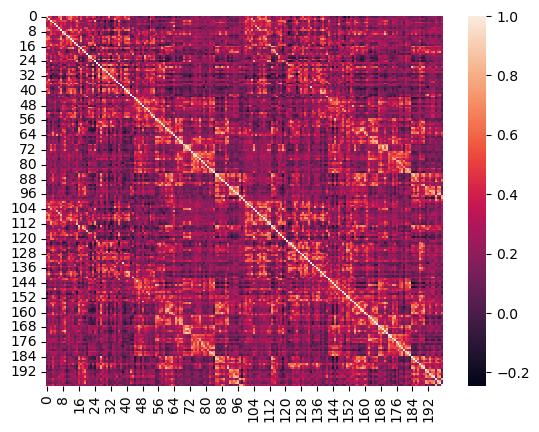

In [19]:
sns.heatmap(A)